# Proyecto "image denoising"

In [2]:
#NumPy: numerical scientific computing 
import numpy as np

#Scikit-learn: machine learning
from sklearn.decomposition import PCA

#Matplotlib: plotting 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

#SciPy: scientific tools
import scipy.io.matlab as matlab


# Carga de los datos

In [145]:
import gzip
import pickle
import sys

f = gzip.open('./data/mnist.pkl.gz')

if sys.version_info < (3,):
    (X_train, y_train), (X_test, y_test) = pickle.load(f)
else:
    (X_train0, y_train), (X_test0, y_test) = pickle.load(f, encoding = "bytes")

print(X_train0.shape)
print(y_train.shape)


(60000, 28, 28)
(60000,)


In [146]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True, parser='auto')
X = MinMaxScaler().fit_transform(X)

Dividimos en train y test e introducimos ruido a las imágenes.

In [147]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, train_size=1_000, test_size=100
)

rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X_test.shape)
X_test_noisy = X_test + noise

noise = rng.normal(scale=0.25, size=X_train.shape) # ruido gaussiano
X_train_noisy = X_train + noise

# Representación de las imágenes

In [148]:
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

# Ejercicio.

### Intenta quitar el ruido de las imágenes de test utilizando los métodos vistos en clase. Cuantifica los resultados cualitativamente y cuantitativamente utilizando MSE. Justifica todas tus respuestas.

Ajustar los hiperparámetros para obtener los mejores resultados posibles (número de componentes, tipo de kernel, gamma ...).

Mostramos primero las imágenes de test sin ruido y con ruido para ver las diferencias visuales.

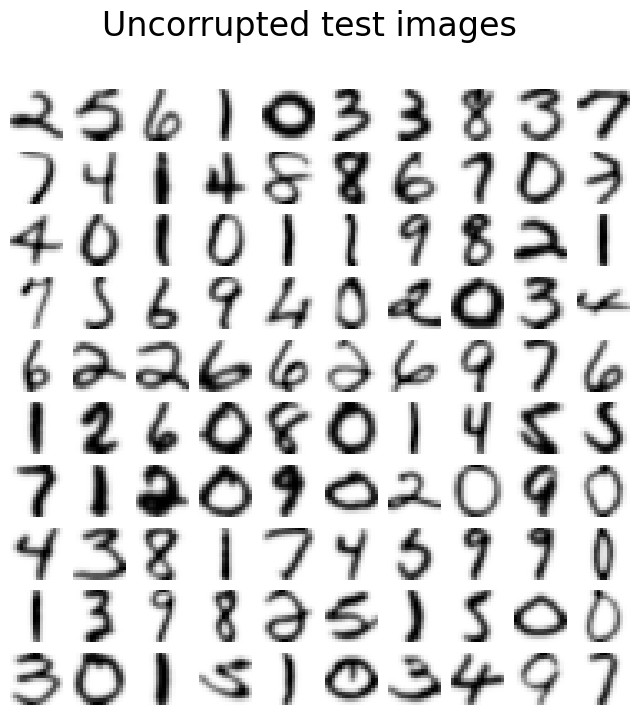

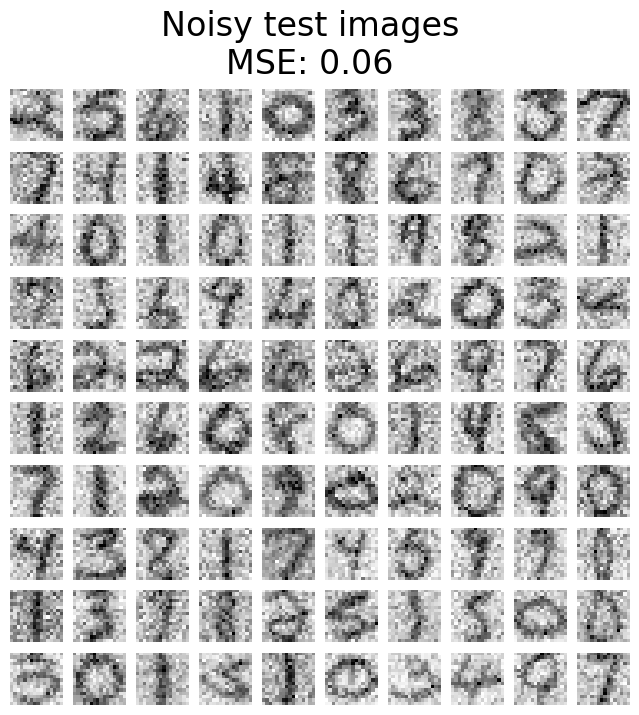

In [149]:
plot_digits(X_test, "Uncorrupted test images")
plot_digits(
    X_test_noisy, f"Noisy test images\nMSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}"
)

Hacemos en primer lugar una PCA con todas las componentes para hallar los autovalores de las distintas componentes principales. Se grafica además la varianza explicada acumulada..

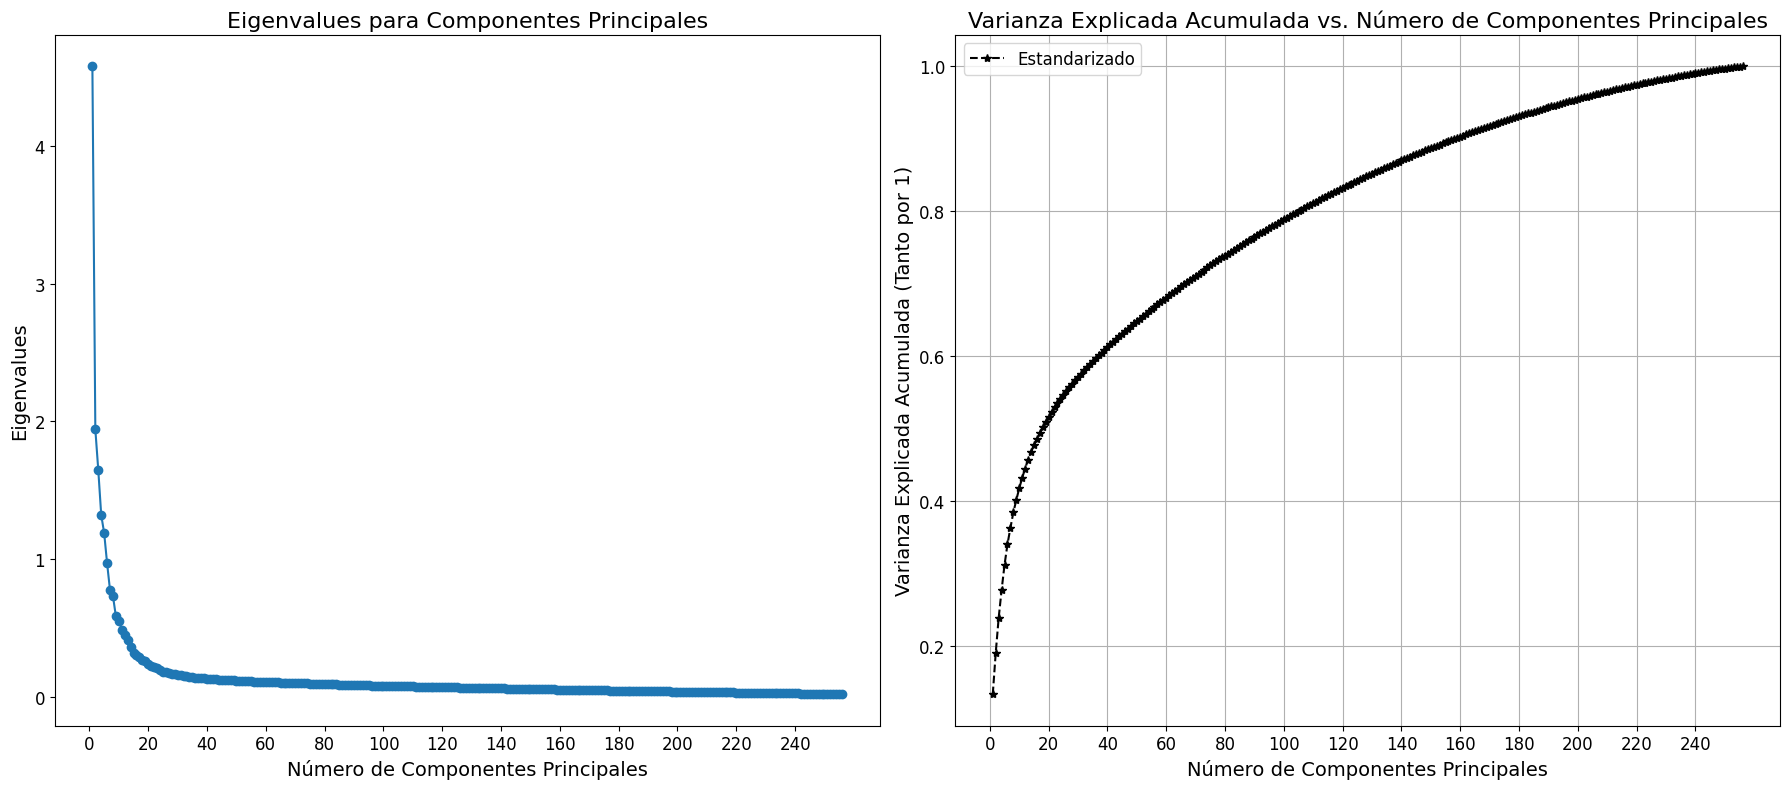

In [150]:
# Ajustar PCA a los datos de entrenamiento
pca = PCA()
pca.fit(X_train_noisy)

# Obtener los eigenvalues
eigenvalues = pca.explained_variance_

# Obtener la varianza explicada acumulada
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
num_components = np.arange(1, len(cumulative_variance_explained) + 1)

# Crear la figura y los subplots en una sola fila
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Subplot 1: Gráfico de eigenvalues
axs[0].plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
axs[0].set_xlabel('Número de Componentes Principales', fontsize=14)
axs[0].set_ylabel('Eigenvalues', fontsize=14)
axs[0].set_title('Eigenvalues para Componentes Principales', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=12)  # Ajustar el tamaño de los ticks
axs[0].set_xticks(np.arange(0, len(eigenvalues) + 1, 20))  # Establecer ticks de x de 5 en 5

# Subplot 2: Gráfico de varianza explicada acumulada
axs[1].plot(num_components, cumulative_variance_explained, linestyle='--', marker='*', color='black', label='Estandarizado')
axs[1].set_xlabel('Número de Componentes Principales', fontsize=14)
axs[1].set_ylabel('Varianza Explicada Acumulada (Tanto por 1)', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].set_title('Varianza Explicada Acumulada vs. Número de Componentes Principales', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=12)  # Ajustar el tamaño de los ticks
axs[1].set_xticks(np.arange(0, len(eigenvalues) + 1, 20))  # Establecer ticks de x de 5 en 5
axs[1].grid(True)

# Ajustar el espacio entre subplots para evitar solapamientos
plt.tight_layout()

# Mostrar el plot
plt.show()

El "codo" aproximadamente se encuentra por 25. Con ese número de componentes visualmente se estima que hay un 95% de la varianza explicada.

In [151]:
from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=25)
kernel_pca = KernelPCA(
    n_components=400,
    kernel="rbf",
    gamma=1e-3,
    fit_inverse_transform=True,
    alpha=5e-3,
    random_state=42,
)

pca.fit(X_train_noisy)
_ = kernel_pca.fit(X_train_noisy)

In [152]:
X_reconstructed_kernel_pca = kernel_pca.inverse_transform(
    kernel_pca.transform(X_test_noisy)
)
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))

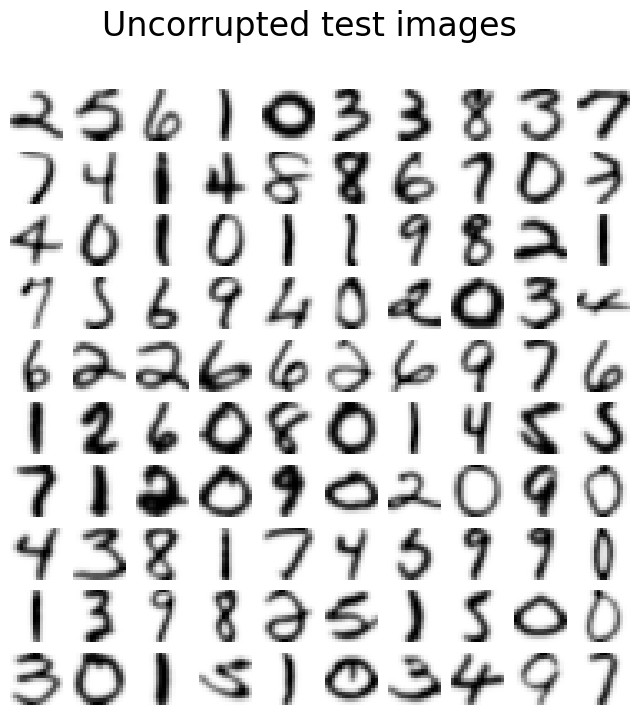

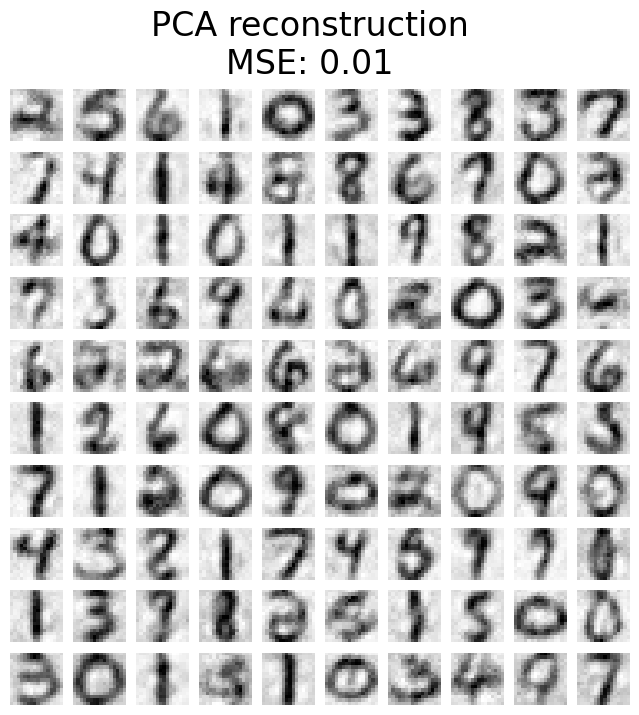

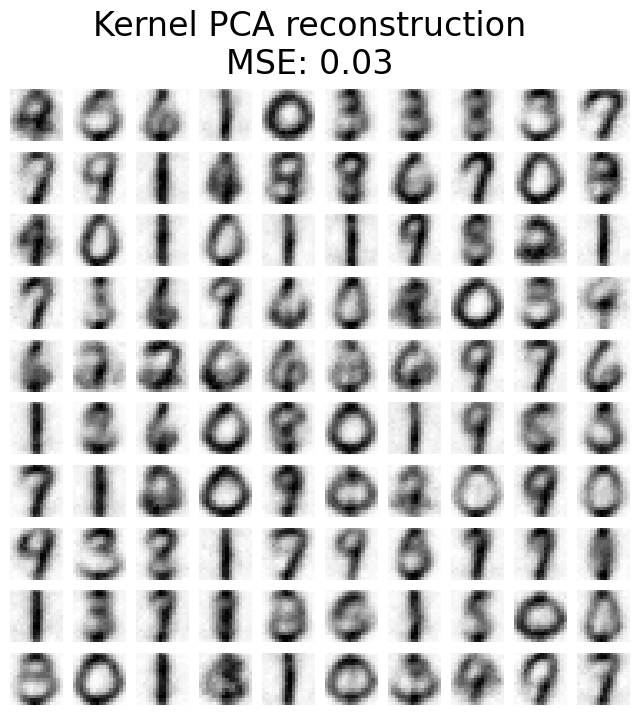

In [153]:
plot_digits(X_test, "Uncorrupted test images")
plot_digits(
    X_reconstructed_pca,
    f"PCA reconstruction\nMSE: {np.mean((X_test - X_reconstructed_pca) ** 2):.2f}",
)
plot_digits(
    X_reconstructed_kernel_pca,
    (
        "Kernel PCA reconstruction\n"
        f"MSE: {np.mean((X_test - X_reconstructed_kernel_pca) ** 2):.2f}"
    ),
)

In [154]:
import itertools

def perform_dimensionality_reduction(X_train_noisy, X_test_noisy, n_components_pca_list, n_components_kpca_list, kernel_types, gamma_values, degrees, alpha_values):
    results = []

    for n_components_pca in n_components_pca_list:
        pca = PCA(n_components=n_components_pca)
        pca.fit(X_train_noisy)
        X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))
        mse_pca = np.mean((X_test - X_reconstructed_pca) ** 2)
        results.append(('PCA', n_components_pca, mse_pca, X_reconstructed_pca))

    for n_components_kpca, kernel_type in itertools.product(n_components_kpca_list, kernel_types):
        if kernel_type == 'poly':
            for gamma, degree, alpha in itertools.product(gamma_values, degrees, alpha_values):
                kernel_pca = KernelPCA(
                    n_components=n_components_kpca,
                    kernel=kernel_type,
                    gamma=gamma,
                    degree=degree,
                    fit_inverse_transform=True,
                    alpha=alpha,
                    random_state=42,
                )
                kernel_pca.fit(X_train_noisy)
                X_reconstructed_kernel_pca = kernel_pca.inverse_transform(kernel_pca.transform(X_test_noisy))
                mse_kpca = np.mean((X_test - X_reconstructed_kernel_pca) ** 2)
                results.append((f'KernelPCA_{kernel_type}_gamma_{gamma}_degree_{degree}_alpha_{alpha}', n_components_kpca, mse_kpca, X_reconstructed_kernel_pca))
        else:
            for gamma, alpha in itertools.product(gamma_values, alpha_values):
                kernel_pca = KernelPCA(
                    n_components=n_components_kpca,
                    kernel=kernel_type,
                    gamma=gamma,
                    fit_inverse_transform=True,
                    alpha=alpha,
                    random_state=42,
                )
                kernel_pca.fit(X_train_noisy)
                X_reconstructed_kernel_pca = kernel_pca.inverse_transform(kernel_pca.transform(X_test_noisy))
                mse_kpca = np.mean((X_test - X_reconstructed_kernel_pca) ** 2)
                results.append((f'KernelPCA_{kernel_type}_gamma_{gamma}_alpha_{alpha}', n_components_kpca, mse_kpca, X_reconstructed_kernel_pca))

    return results

# Ejemplo de uso
# Definir listas de diferentes números de componentes para PCA y KernelPCA
n_components_pca_list = [10, 20, 50]
n_components_kpca_list = [200, 400]
kernel_types = ['rbf', 'cosine', 'poly']
gamma_values = [1e-3, 2e-3, 1e-2]
degrees = [2, 3]
alpha_values = [5e-3]

# Realizar el barrido de dimensionalidad
results = perform_dimensionality_reduction(X_train_noisy, X_test_noisy, n_components_pca_list, n_components_kpca_list, kernel_types, gamma_values, degrees, alpha_values)


C:\Users\jesus\AppData\Local\Temp\ipykernel_15592\1506662233.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))


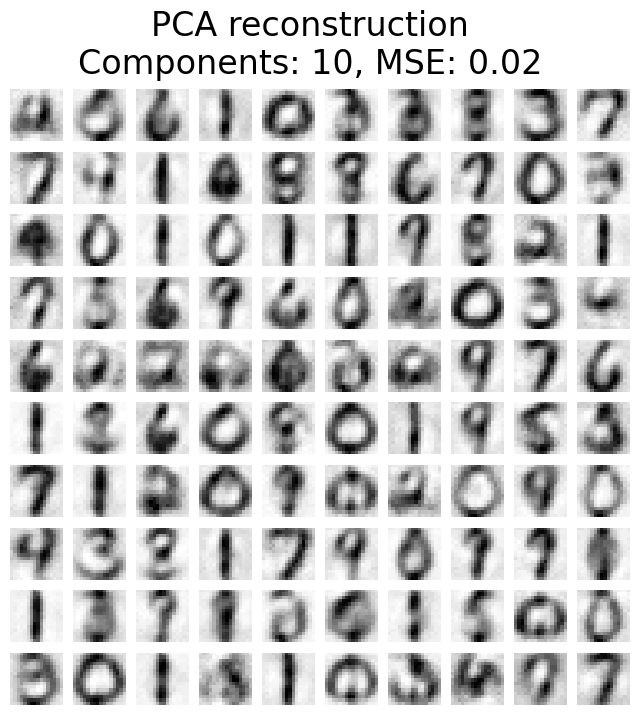

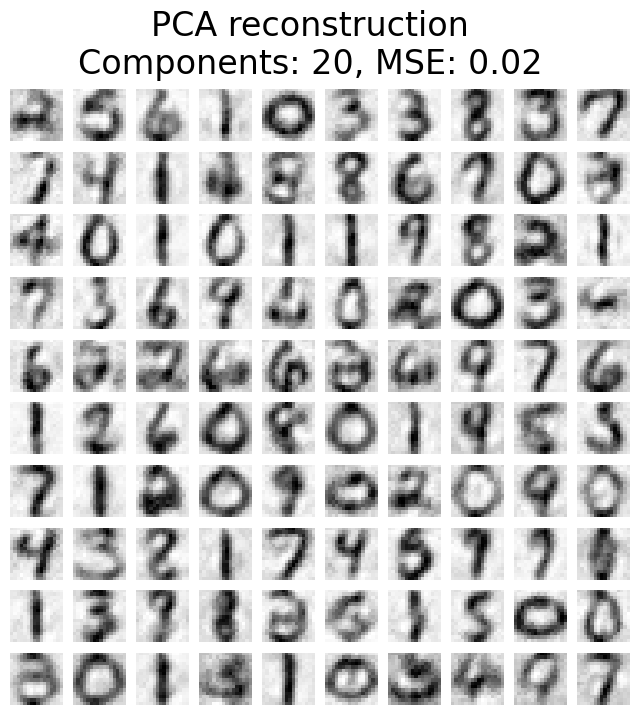

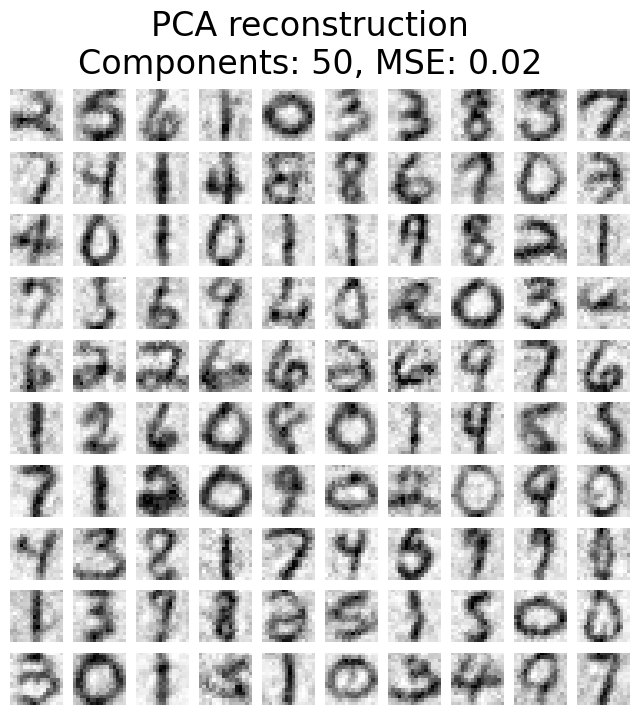

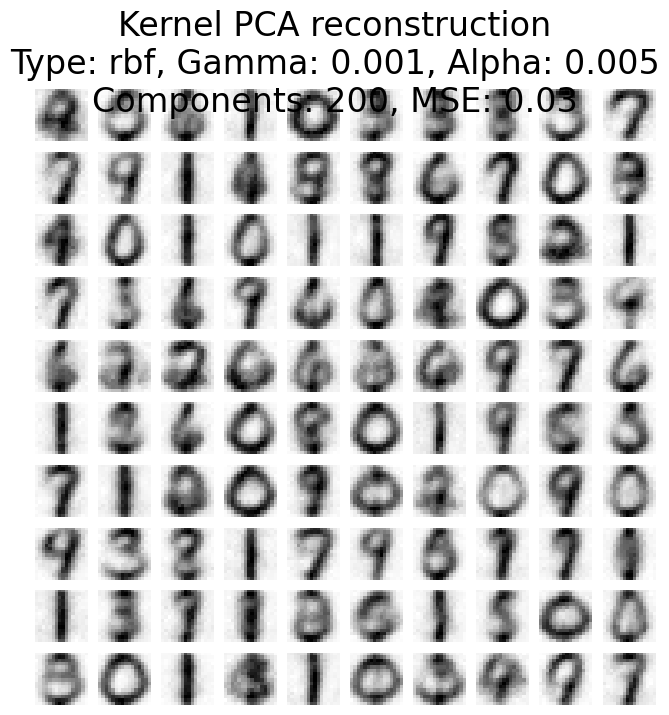

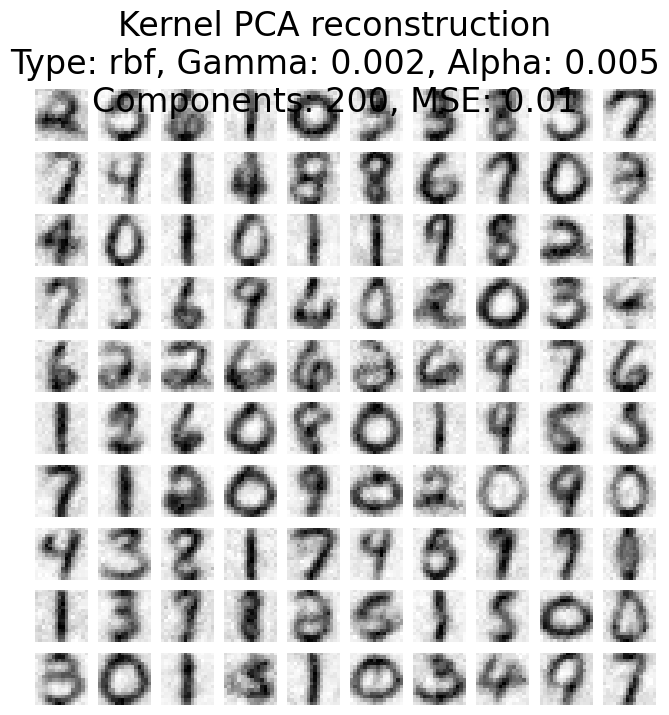

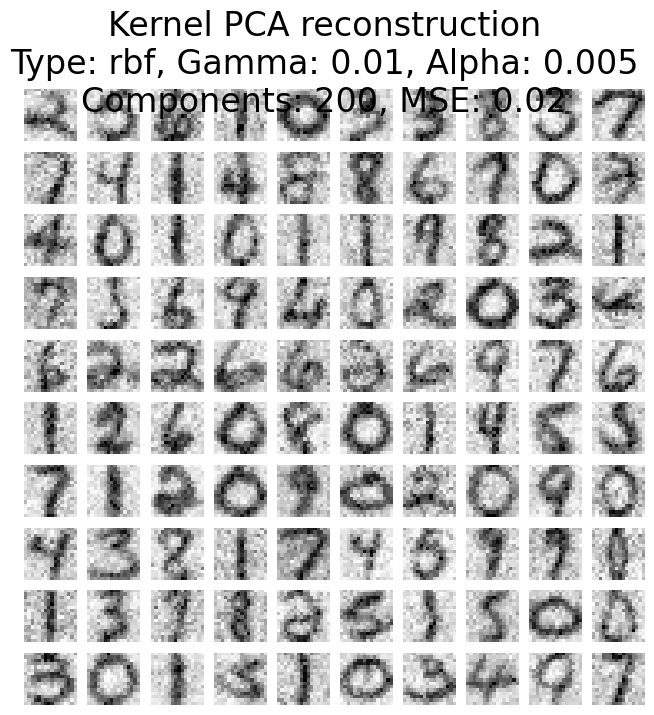

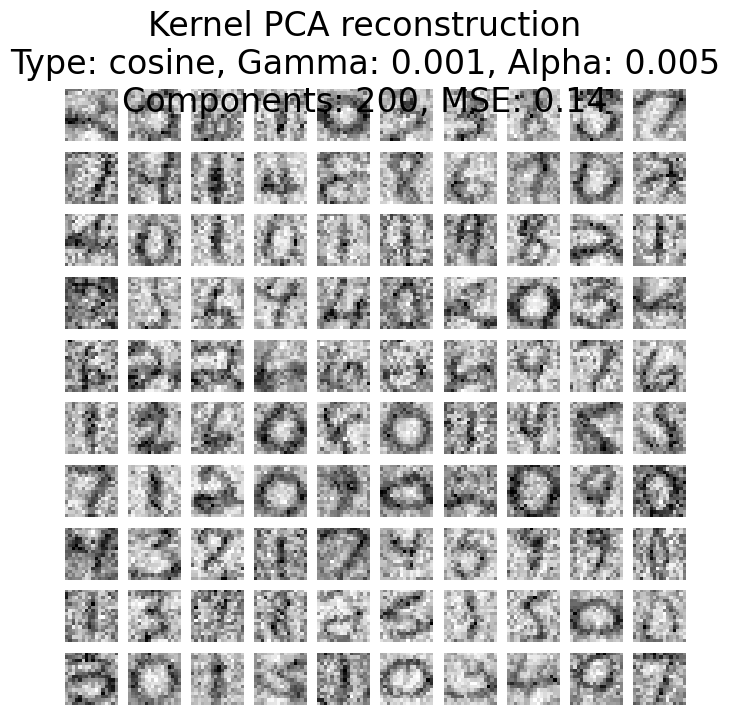

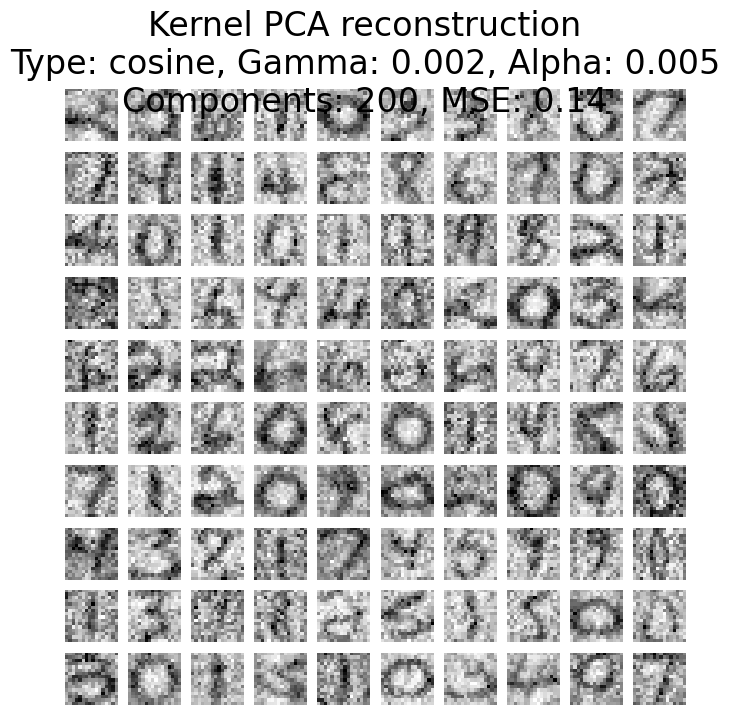

Error in callback <function flush_figures at 0x000001AB967319E0> (for post_execute):


KeyboardInterrupt: 

In [156]:
def plot_results_from_results(results):
    """Plot reconstructed images from results."""
    for method, n_components, mse, X_reconstructed in results:
        if method.startswith('KernelPCA'):
            params = method.split('_')
            kernel_type = params[1]
            gamma = params[3]
            if kernel_type == 'poly':
                degree = params[5]
                alpha = params[7]
                title = f"Kernel PCA reconstruction\nType: {kernel_type}, Gamma: {gamma}, Degree: {degree}, Alpha: {alpha}\nComponents: {n_components}, MSE: {mse:.3f}"
            else:
                alpha = params[5]
                title = f"Kernel PCA reconstruction\nType: {kernel_type}, Gamma: {gamma}, Alpha: {alpha}\nComponents: {n_components}, MSE: {mse:.3f}"
        else:
            title = f"PCA reconstruction\nComponents: {n_components}, MSE: {mse:.3f}"
        plot_digits(X_reconstructed, title)

# Ejemplo de uso
plot_results_from_results(results)
